## Classifying Banksy with a Binary CNN

This assignment aims to pull the techniques gathered throughout the visual analytics course together into one line of exploration. The project takes the topic of graffiti artist Banksy and considers whether machine learning can shed new light into our understanding of his work and the hype surrounding his anonymous façade. Namely it asks, how unique is Banksy’s street art and how easily could it be faked by another? 

A key focus of the assignment is demonstrating how one could go about gathering an image dataset to be used in computer vision tasks. This is in recognition that many computer vision projects use the same large datasets such as MNIST, ImageNet, or CIFAR-10. While these are useful resources, for true development to be made we need to be testing the tools used on these popular image collections on new sets of data, to evaluate both how useful and how generalisable the models are in their current state. These insights help the field to advance and allow us to apply the tools into many more fields, such as cultural data science. Therefore, much of this assignment looks at the process of how to collect a dataset and considers what problems can arise throughout this process. It then applies the collected dataset into an AlexNet CNN model to see how well it will perform in classifying between inages of Banksy and other Street art. 

This notebook contains the final parts of the code used to build the AlexNet binary classifier for the final assignment in the visual analytics portfolio, Spring 2021.

__Importing the dependencies__

In [1]:
# Operating system
import os
import sys
sys.path.append(os.path.join(".."))

# Data handling tools
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import glob
from contextlib import redirect_stdout

#Functions from the utils folder
import utils.Banksy_CNN_utils as functions

#Commandline functionality 
import argparse

# Sklearn tools
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report

# TensorFlow tools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, 
                                     MaxPooling2D, 
                                     Activation, 
                                     Flatten, 
                                     Dense,
                                     Dropout)
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K


In [ ]:
#Setting up the path 
data_path = "data/test"

__Function for extracting labels from filenames__

In [41]:
# Create empty list
label_names = []
    
# For every name in training directory
for name in os.listdir(data_path):
    # If it does not start with . (which hidden files do)
    if not name.startswith('.'):
        label_names.append(name)
        
print(label_names)

['Other_Streetart', 'Banksy_Streetart']


__Function to grab the images, resize them, and put them into a NumPy array format__

In [42]:
def get_data (data_path, label_names):
    """
    The function creates the data and label sets to be as follows:
    data = The image data  
    label = The class labels   
    """
    # Create empty array and list
    data = np.empty((0, 227, 227, 3))
    label = []
    
    
    # Loop through images in training data
    for name in label_names:
        images = glob.glob(os.path.join(data_path, name, "*.jpg"))
        
        # For each image
        for image in tqdm(images):
        
            # Load image
            loaded_img = cv2.imread(image)
        
            # Resize image with the specified dimensions using cv2's resize function
            # We'll use the dimensions used by the AlexNet architechture 
            resized_img = cv2.resize(loaded_img, (227, 227), interpolation = cv2.INTER_AREA)
        
            # Create array of image
            image_array = np.array([np.array(resized_img)])
        
            # Append the image array to the trainX
            data = np.vstack((data, image_array))
            
            # Append the label name to the trainY list
            label.append(name)
        
    return data, label

__Loading in the data__



In [45]:
data, label = get_data(data_path, label_names)

100%|██████████| 851/851 [10:05<00:00,  1.41it/s]


__Splitting the data into a train and test set__

In [46]:
# split data
(trainX, testX, trainY, testY) = train_test_split(data, 
                                                  label, 
                                                  test_size=0.2)

__Normalising the image data and binarising the labels__

In [52]:
# Normalize training and test data
trainX = trainX.astype("float") / 255.
testX = testX.astype("float") / 255.
    
# Binarize training and test labels
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.fit_transform(testY)

In [54]:
print(trainX, 10)

[[[[0.72941176 0.68235294 0.6745098 ]
   [0.75294118 0.70588235 0.69803922]
   [0.75686275 0.70980392 0.70196078]
   ...
   [0.79607843 0.78823529 0.75294118]
   [0.74509804 0.76078431 0.70588235]
   [0.72156863 0.74901961 0.68235294]]

  [[0.72941176 0.68235294 0.6745098 ]
   [0.74117647 0.69411765 0.68627451]
   [0.7372549  0.69019608 0.68235294]
   ...
   [0.76862745 0.76078431 0.72941176]
   [0.72941176 0.71372549 0.70196078]
   [0.77254902 0.75294118 0.74901961]]

  [[0.74509804 0.69803922 0.69019608]
   [0.76862745 0.72156863 0.71372549]
   [0.77254902 0.7254902  0.71764706]
   ...
   [0.74509804 0.74117647 0.70588235]
   [0.75686275 0.74117647 0.70588235]
   [0.75686275 0.73333333 0.7254902 ]]

  ...

  [[0.62352941 0.65882353 0.69803922]
   [0.61568627 0.65098039 0.69019608]
   [0.64705882 0.68235294 0.72156863]
   ...
   [0.63921569 0.71372549 0.74509804]
   [0.61176471 0.69411765 0.7254902 ]
   [0.63137255 0.72156863 0.75294118]]

  [[0.62352941 0.65882353 0.69803922]
   [0.6

# Building the model

In [56]:
#Now we have new train and test split, we can define the model 

##BINARY CLASSIFICATION MODEL

#Ensure old session is cleared 
K.clear_session()

#Set in an Early stop callback - this stops the model running if it doesn't learn anything in 3 epochs 
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    
model = Sequential()

# Convolutional layer and maxpool layer 1
model.add(Conv2D(32,(11,11),activation='relu',input_shape=(227,227,3)))
model.add(MaxPooling2D(3,3))

# Convolutional layer and maxpool layer 2
model.add(Conv2D(64,(5,5),activation='relu', padding="same"))
model.add(MaxPooling2D(3,3))

# Convolutional layer and maxpool layer 3 (No maxpool layer) 
model.add(Conv2D(128,(3,3),activation='relu', padding="same"))

# Convolutional layer and maxpool layer 4
model.add(Conv2D(256,(3,3),activation='relu', padding="same"))
    
# Convolutional layer and maxpool layer 5
model.add(Conv2D(512,(3,3),activation='relu', padding="same"))
model.add(MaxPooling2D(3,3))

# This layer flattens the resulting image array to 1D array
model.add(Flatten())

# Hidden layer with 4096 neurons and Rectified Linear Unit activation function 
model.add(Dense(4096,activation='relu'))
model.add(Dropout(0.5))
    
# Hidden layer 2 with 4096 neurons and Rectified Linear Unit activation function 
model.add(Dense(4096,activation='relu'))
model.add(Dropout(0.5))

# Output layer with single neuron which gives 0 for Banksy or 1 for Other Streetrt  
#Here we use sigmoid activation function which makes our model output to lie between 0 and 1
model.add(Dense(1,activation='sigmoid'))
    
model.compile(optimizer='adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

    
# Model summary
model_summary = model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 217, 217, 32)      11648     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 72, 72, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 256)       295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 512)       1

__Training the model__

In [57]:
# fit model and save fitting hisotry
H = model.fit(trainX, trainY,
                validation_data=(testX, testY), 
                batch_size=32, 
                epochs=20, 
                verbose=1,
                callback = [callback])


Epoch 1/20
51/51 [==============================] - 170s 3s/step - loss: 0.8395 - accuracy: 0.5488 - val_loss: 0.7046 - val_accuracy: 0.5332
Epoch 2/20
51/51 [==============================] - 131s 3s/step - loss: 0.6825 - accuracy: 0.5829 - val_loss: 0.6950 - val_accuracy: 0.5332
Epoch 3/20
51/51 [==============================] - 127s 3s/step - loss: 0.6851 - accuracy: 0.5599 - val_loss: 0.7087 - val_accuracy: 0.5332
Epoch 4/20
51/51 [==============================] - 140s 3s/step - loss: 0.6812 - accuracy: 0.5858 - val_loss: 0.7009 - val_accuracy: 0.5332
Epoch 5/20
51/51 [==============================] - 168s 3s/step - loss: 0.6740 - accuracy: 0.5965 - val_loss: 0.6941 - val_accuracy: 0.5332
Epoch 6/20
51/51 [==============================] - 166s 3s/step - loss: 0.6740 - accuracy: 0.5944 - val_loss: 0.6894 - val_accuracy: 0.5356
Epoch 7/20
51/51 [==============================] - 168s 3s/step - loss: 0.6465 - accuracy: 0.6300 - val_loss: 0.6209 - val_accuracy: 0.6216
Epoch 8/20
51

__Creaing the classification report__

In [85]:
#The label names in this model are very sensitive as predictions is a float number while testY is a binary 0 or 1.
#This means we need the .round() at the end of predictions in the classification report to ensure both labels are 0s and 1s
label_names = ["Banksy_Streetart", "Other_Streetart"]

predictions = model.predict(testX, batch_size=32)
classification = classification_report(testY,
                                      predictions.round(),
                                      target_names=label_names)
print(classification)

                  precision    recall  f1-score   support

Banksy_Streetart       0.68      0.82      0.74       190
 Other_Streetart       0.81      0.67      0.73       217

        accuracy                           0.74       407
       macro avg       0.74      0.74      0.74       407
    weighted avg       0.75      0.74      0.74       407



__Visualising the model history__

In [63]:
#Save a picture of the model 
def plot_history(H, n_epochs):
    """
    This function plots the loss/accuracy of the model during training and saves this as png file in the out folder.
    It uses matplotlib tools to create the plot.
    """
    # name for saving output
    figure_path = os.path.join("..", "out", "model_history.png")
    # Visualize performance
    plt.style.use("fivethirtyeight")
    plt.figure()
    plt.plot(np.arange(0, n_epochs), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, n_epochs), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, n_epochs), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, n_epochs), H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.savefig(figure_path)

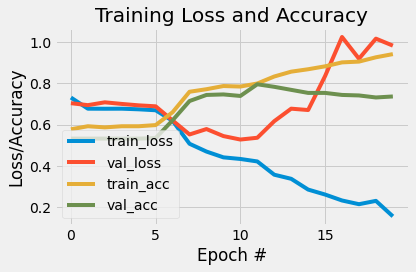

In [64]:
#Print out our model training loss accuracy 
plot_history(H, 20) 

The model history shows us that the model is learning fair well with a continuously falling traning_loss (blue curve) and continuously rising training accuracy curve(yellow). However, our validation curves tells us another story and indicate th the model appears to be overfitting after around 10 epochs. At this stage, the validation loss curve stops falling and begins to rise again(red), while the validation accuracy curve (green) begins to fall, telling us that the model is performing worse after 10 epochs. 